In [1]:
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units 
from IPython.display import HTML, display
import imageio
from tqdm import tqdm
from itertools import product
import wrf
import glob
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import TwoSlopeNorm

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
#Create Path For Data Collection and Create A List of File Names
storm16_data_path = '/storage/work/bsh5393/storm16/'
storm16_files = os.listdir(storm16_data_path)

#Remove Unneccessary Files From Storm 16 File List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')

#Read in Raw Trajectories

#Step 1: Initialization and Input Parameters

#Data at t = 2hrs
storm_data = xr.open_dataset(storm16_data_path + storm16_files[-1])

#Dataset Domain Size
ni = storm_data['ni']
nj = storm_data['nj']
nk = storm_data['nk']

#Datapoint Locations
x_data = storm_data['xh']*units.kilometer
y_data = storm_data['yh']*units.kilometer
z_data = storm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = storm_data['xf']*units.kilometer
y_grid = storm_data['yf']*units.kilometer
z_grid = storm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values - (x_data[-1].values-25)).argmin()-2
upper_bound_x = np.abs(x_data.values - (x_data[-1].values)).argmin()
lower_bound_y = np.abs(y_data.values - 15).argmin()
upper_bound_y = np.abs(y_data.values - 40).argmin()+1
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(1,len(storm16_files),1):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0]+30 #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon

In [3]:
#Raw Interpolated Data

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'

#read full dataset in
full_data = np.load(path + "all_raw_interp_data.npz")

#Create Variables 
interp_points = full_data['interp_points']
interp_u = full_data['interp_u']
interp_v = full_data['interp_v']
interp_th = full_data['interp_th']
interp_p = full_data['interp_p']
interp_qv = full_data['interp_qv']

In [4]:
#Raw Data Interpolated Down To Grid (model scalar z-points)

path =  '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'

#read full dataset in
interp_down_data = np.load(path + "data_interp_2_model_grid.npz")

#Create Variables 
pres_grid = interp_down_data['pressure']
th_grid = interp_down_data['th']
qv_grid = interp_down_data['qv']
u_grid = interp_down_data['u']
v_grid = interp_down_data['v']
z_levels = z_data.values

100%|██████████| 100/100 [00:00<00:00, 2233.03it/s]


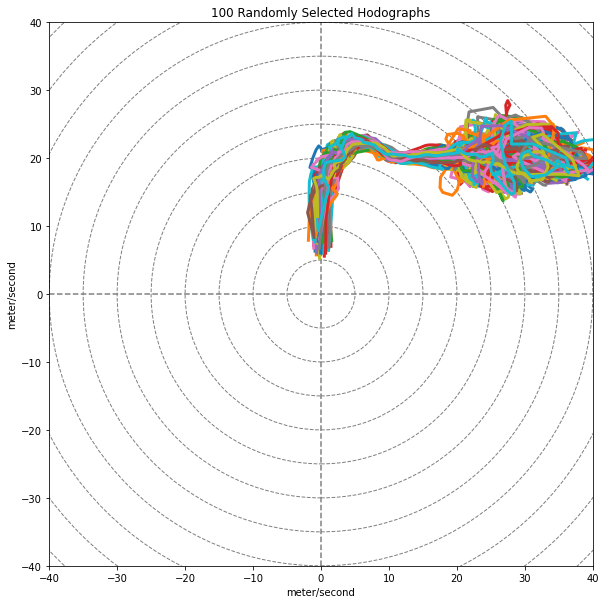

In [11]:
#Create Hodographs
#This doesn't look good due to the linear interpolation at the top of the domain
#look into the "kind" argument in scipy.interpolate.interp1d documentation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

offset_u = 12.2
offset_v = 12.5
fig, ax = plt.subplots(figsize = (10,10))
h = metpy.plots.Hodograph(ax, component_range=40.)
h.add_grid(increment=5)

for x in tqdm(range(100)):
    i = np.random.randint(0,335**2)
    h.plot(u_grid[:,i]+offset_u, v_grid[:,i]+offset_v)
    plt.title(f'100 Randomly Selected Hodographs')
    plt.xlabel('meter/second')
    plt.ylabel('meter/second')

In [22]:
#Create GIF of 100 Hodographs being plotted 

#Establish Path

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/FigureBuilder/'
gifname = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/GIFs/100indrandhodos.gif'

#initialize hodograph
offset_u = 12.2
offset_v = 12.5

for j in tqdm(range(100)):
    fig, ax = plt.subplots(figsize = (10,10))
    h = metpy.plots.Hodograph(ax, component_range=40.)
    h.add_grid(increment=5)
    plt.xlabel('meter/second')
    plt.ylabel('meter/second')

    image_filename = "figure_%03d.png" % (j)
    i = np.random.randint(0,335**2)
    h.plot(u_grid[:,i]+offset_u, v_grid[:,i]+offset_v)
    plt.title(f'100 Randomly Selected Hodographs (Point ID: {i})')
    #Save the figure
    fig.savefig(path + image_filename)
    
    #clear 
    plt.close()
    
#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.1
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles[:j]:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[:j]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())


100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


In [ ]:
#Compute Temperature from pressure and potential temperature using adiabatic relationship
def comp_T_from_Th(pressure, pot_temperature):
    P_0 = 100000
    R_d = 287 #J/(kg*K)
    c_p = 1004 #J/(kg*K)
    K = R_d/c_p
    T = pot_temperature*(P_0/pressure)**(-K)
    
    return T;

#Compute Dewpoint Temperature from pressure, temperature, and specific humidity
def comp_dewpoint(pressure, temperature, specific_humidity):
    
    q = specific_humidity
    eps = 0.622
    
    #mixing ratio
    w = q/(1-q)
    
    #vapor pressure (in Pa converted to mb)
    e = 0.01*(pressure*w)/(eps+w)
    
    #Dewpoint from Bolton 1980
    T = (243.5*np.log(e/6.112))/(17.67-np.log(e/6.112))+273.15
    
    return T;
    
    

In [5]:
#Now Let's Work on Doing Calculations To Create Soundings 

#Create New Variables

T = np.zeros(pres_grid.shape)
Td = np.zeros(pres_grid.shape)

#I personally don't like metpy for the calculations. I'm going to create two functions that do metpy things better.
for i in tqdm(np.arange(0,pres_grid.shape[1],1)):
    T[:,i] = comp_T_from_Th(pres_grid[:,i], th_grid[:,i])
    Td[:,i] = comp_dewpoint(pres_grid[:,i], T[:,i], qv_grid[:,i])
    

  0%|          | 0/112225 [00:00<?, ?it/s]


NameError: name 'comp_T_from_Th' is not defined

In [9]:
#Compute Parcel Profile
parcel_prof = np.zeros(pres_grid.shape)

for i in tqdm(np.arange(0,pres_grid.shape[1], 1)):
    parcel_prof[:,i] = (metpy.calc.parcel_profile(pres_grid[:,i]*units.Pa, (T[:,i]*units.kelvin)[0], (Td[:,i]*units.kelvin)[0])).magnitude


100%|██████████| 112225/112225 [2:11:23<00:00, 14.24it/s] 


In [11]:
#Save The Data Interpolated Down to Model Domain
#Before moving forward, save all interpolated data so we don't need to recalculate each time

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'

#Save as a .npz file
np.savez(path+'raw_data_2_grid', pressure = pres_grid, th = th_grid, qv = qv_grid, u = u_grid, v = v_grid, parcel_T = parcel_prof)


In [33]:
#load data interpolated to model scalar grid 
path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'
#data 
test = np.load(path + "pseudo_data.npz")

#Add Temperature and Dewpoint temperature

parc_T = test['parcel_T']

np.savez(path+'raw_data_2_grid', pressure = pres_grid, th = th_grid, T = T, Td = Td, qv = qv_grid, u = u_grid, v = v_grid, parcel_T = parc_T)


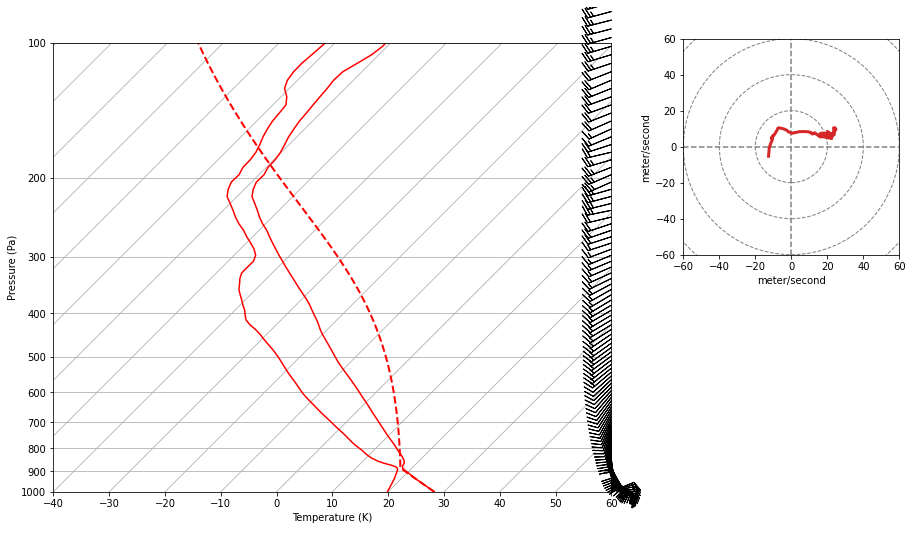

In [39]:
#Plotting a Single Sounding To Check

fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(pres_grid[:,i-1]*units.Pa, T[:,i-1]*units.kelvin, 'r')
skew.plot(pres_grid[:,i-1]*units.Pa, Td[:,i-1]*units.kelvin, 'r')
skew.plot_barbs(pres_grid[:,i-1]*units.Pa, u_grid[:,i-1]*units('m/s'), v_grid[:,i-1]*units('m/s'))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Set some better labels than the default
#skew.ax.set_title('Domain Environmental Profile at t = 0 hrs')
skew.ax.set_xlabel(f'Temperature ({(T[:,i-1]*units.kelvin).units:~P})')
skew.ax.set_ylabel(f'Pressure ({(pres_grid[:,i-1]*units.Pa).units:~P})')

# Calculate full parcel profile and add to plot as black line
#prof = mpcalc.parcel_profile(p_avg, T_avg[0], Td_avg[0]).to('degC')
skew.plot(pres_grid[:,i-1]*units.Pa, parc_T[:,i-1]*units.kelvin, 'r--', linewidth=2)

# Add the relevant special lines
#skew.plot_dry_adiabats()
#skew.plot_moist_adiabats()
#skew.plot_mixing_lines()

#Relative Storm Motion 
#offset_u = 12.2*units.meter_per_second
#offset_v = 12.5*units.meter_per_second

#Add Hodograph
ax = plt.axes((1, 0.52, 0.3, 0.3))
h = metpy.plots.Hodograph(ax, component_range=60.)
h.add_grid(increment=20)
h.plot(u_grid[:,i-1]*units('m/s'), v_grid[:,i-1]*units('m/s'), color='tab:red')

# Show the plot
plt.show()


In [42]:
#Try to Plot Multiple (Tweak This To Pick 100 Random Soundings)

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/FigureBuilder/'
gifname = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/GIFs/pseudosoundings.gif'


for x in tqdm(range(100)):
    
    k = np.random.randint(0,335**2)
    image_filename = "figure_%03d.png" % (x)
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot.
    fig = plt.figure(figsize=(15,10))
    skew = SkewT(fig, rotation=45)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 60)
    skew.plot(pres_grid[:,k]*units.Pa, T[:,k]*units.kelvin, 'r')
    skew.plot(pres_grid[:,k]*units.Pa, Td[:,k]*units.kelvin, 'r')
    skew.plot_barbs(pres_grid[:,k]*units.Pa, u_grid[:,k]*units('m/s'), v_grid[:,k]*units('m/s'))

    # Set some better labels than the default
    skew.ax.set_title(f'100 Random PseudoSoundings (ID: {k})')
    skew.ax.set_xlabel(f'Temperature ({(T[:,k]*units.kelvin).units:~P})')
    skew.ax.set_ylabel(f'Pressure ({(pres_grid[:,k]*units.Pa).units:~P})')

    # Calculate full parcel profile and add to plot as black line
    #prof = mpcalc.parc_T(p_avg, T_avg[0], Td_avg[0]).to('degC')
    skew.plot(pres_grid[:,k]*units.Pa, parc_T[:,k]*units.kelvin, 'r--', linewidth=2)

    # Add the relevant special lines
    #skew.plot_dry_adiabats()
    #skew.plot_moist_adiabats()
    #skew.plot_mixing_lines()

    #Relative Storm Motion 
    offset_u = 12.2*units.meter_per_second
    offset_v = 12.5*units.meter_per_second
    #Add Hodograph
    ax_hodograph = fig.add_axes([.84, 0.7, 0.18, 0.18])
    h = metpy.plots.Hodograph(ax_hodograph, component_range=40.)
    h.add_grid(increment=5)
    h.plot(u_grid[:, k] * units('m/s')+offset_u, v_grid[:, k] * units('m/s')+offset_v, color='tab:red')
    
    #Save the figure
    fig.savefig(path + image_filename)
    
    #clear the figure
    plt.close()


100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


In [44]:
#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.2
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles[:x]:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[:x]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

In [6]:
#Storm16 dataset
inst_data = xr.open_dataset(storm16_data_path + storm16_files[1])

#Divy out the dataset to save the important fields
inst_pres = inst_data['prs'].isel(time=0)
inst_th = inst_data['th'].isel(time=0)
inst_qv = inst_data['qv'].isel(time=0)
inst_u = inst_data['uinterp'].isel(time=0)
inst_v = inst_data['vinterp'].isel(time=0)

In [20]:
#Need to Find Closest Point on Model Grid To Chosen Trajectory Point

#index of random point
i = 17216

#random trajectory point at the surface
rand_point = interp_points[0,i]

#decompose into components
rp_x = rand_point[2]
rp_y = rand_point[1]
rp_z = rand_point[0]

#model scalar points grid
x = x_data.values
y = y_data.values
z = z_data.values

#find closest model scalar points in the x & y direction
sx = np.searchsorted(x, rp_x)
sy = np.searchsorted(y, rp_y)

#select the appropriate vertical profile
i_P = inst_pres.loc[:,sy,sx].values
i_Th = inst_th.loc[:,sy,sx].values
i_qv = inst_qv.loc[:,sy,sx].values
i_u = inst_u.loc[:,sy,sx].values
i_v = inst_v.loc[:,sy,sx].values

#Compute T and Td 
#Create New Variables

i_T = np.zeros(z_data.shape)
i_Td = np.zeros(z_data.shape)

#I personally don't like metpy for the calculations. I'm going to create two functions that do metpy things better.

i_T = comp_T_from_Th(i_P, i_Th)
i_Td = comp_dewpoint(i_P, i_T, i_qv)

#compute instantaneous parcel profile 
i_parc_prof = (metpy.calc.parcel_profile(i_P*units.Pa, i_T[0]*units.kelvin, i_Td[0]*units.kelvin).magnitude)

NameError: name 'parc_T' is not defined

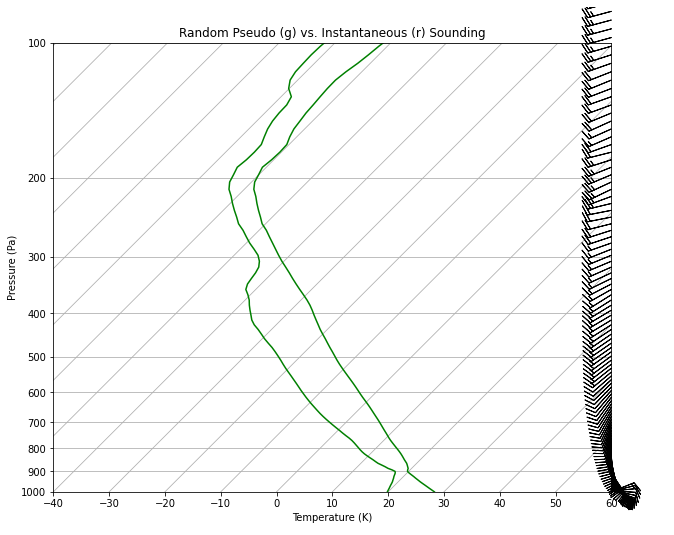

In [14]:
#Plotting Instantaneous vs.Pseudosounding

fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)
#Add Title
plt.title('Random Pseudo (g) vs. Instantaneous (r) Sounding')


#PSEUDO
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(pres_grid[:,i]*units.Pa, T[:,i]*units.kelvin, 'g')
skew.plot(pres_grid[:,i]*units.Pa, Td[:,i]*units.kelvin, 'g')
skew.plot_barbs(pres_grid[:,i]*units.Pa, u_grid[:,i]*units('m/s'), v_grid[:,i]*units('m/s'))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Set some better labels than the default
#skew.ax.set_title('Domain Environmental Profile at t = 0 hrs')
skew.ax.set_xlabel(f'Temperature ({(T[:,i]*units.kelvin).units:~P})')
skew.ax.set_ylabel(f'Pressure ({(pres_grid[:,i]*units.Pa).units:~P})')

# Calculate full parcel profile and add to plot as black line
#prof = mpcalc.parcel_profile(p_avg, T_avg[0], Td_avg[0]).to('degC')
skew.plot(pres_grid[:,i]*units.Pa, parc_T[:,i]*units.kelvin, 'g.', linewidth=2)

#INSTANTANEOUS 
# Add the relevant special lines
#skew.plot_dry_adiabats()
#skew.plot_moist_adiabats()
#skew.plot_mixing_lines()
skew.plot(i_P*units.Pa, i_T*units.kelvin, 'r')
skew.plot(i_P*units.Pa, i_Td*units.kelvin, 'r')
skew.plot_barbs(i_P*units.Pa, i_u*units('m/s'), i_v*units('m/s'))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Set some better labels than the default
#skew.ax.set_title('Domain Environmental Profile at t = 0 hrs')
skew.ax.set_xlabel(f'Temperature ({(i_T*units.kelvin).units:~P})')
skew.ax.set_ylabel(f'Pressure ({(i_P*units.Pa).units:~P})')

# Calculate full parcel profile and add to plot as black line
#prof = mpcalc.parcel_profile(p_avg, T_avg[0], Td_avg[0]).to('degC')
skew.plot(i_P*units.Pa, i_parc_prof*units.kelvin, 'r--', linewidth=2)
#Relative Storm Motion 
#offset_u = 12.2*units.meter_per_second
#offset_v = 12.5*units.meter_per_second

#Add Hodograph
ax = plt.axes((1, 0.52, 0.3, 0.3))
h = metpy.plots.Hodograph(ax, component_range=60.)
h.add_grid(increment=20)
h.plot(i_u*units('m/s')+offset_u, i_v*units('m/s')+offset_v, color='tab:red')
h.plot(u_grid[:,i]*units('m/s')+offset_u, v_grid[:,i]*units('m/s')+offset_v, color='tab:green')

# Show the plot
plt.show()


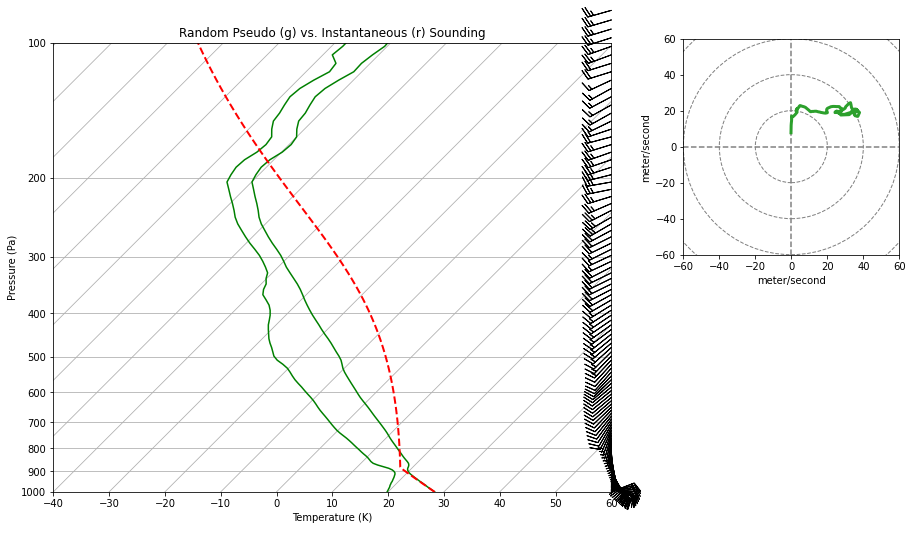

In [21]:
#Plotting Pseudosounding

fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)
#Add Title
plt.title('Random Pseudo (g) vs. Instantaneous (r) Sounding')


#PSEUDO
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(pres_grid[:,i]*units.Pa, T[:,i]*units.kelvin, 'g')
skew.plot(pres_grid[:,i]*units.Pa, Td[:,i]*units.kelvin, 'g')
skew.plot_barbs(pres_grid[:,i]*units.Pa, u_grid[:,i]*units('m/s'), v_grid[:,i]*units('m/s'))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Set some better labels than the default
#skew.ax.set_title('Domain Environmental Profile at t = 0 hrs')
skew.ax.set_xlabel(f'Temperature ({(T[:,i]*units.kelvin).units:~P})')
skew.ax.set_ylabel(f'Pressure ({(pres_grid[:,i]*units.Pa).units:~P})')

# Calculate full parcel profile and add to plot as black line
#prof = mpcalc.parcel_profile(p_avg, T_avg[0], Td_avg[0]).to('degC')
#skew.plot(pres_grid[:,i]*units.Pa, parc_T[:,i]*units.kelvin, 'g.', linewidth=2)

# Calculate full parcel profile and add to plot as black line
#prof = mpcalc.parcel_profile(p_avg, T_avg[0], Td_avg[0]).to('degC')
skew.plot(i_P*units.Pa, i_parc_prof*units.kelvin, 'r--', linewidth=2)
#Relative Storm Motion 
#offset_u = 12.2*units.meter_per_second
#offset_v = 12.5*units.meter_per_second

#Add Hodograph
ax = plt.axes((1, 0.52, 0.3, 0.3))
h = metpy.plots.Hodograph(ax, component_range=60.)
h.add_grid(increment=20)
offset_u =12.2*units('m/s')
offset_v =12.5*units('m/s')
#h.plot(i_u*units('m/s')+offset_u, i_v*units('m/s')+offset_v, color='tab:red')
h.plot(u_grid[:,i]*units('m/s')+offset_u, v_grid[:,i]*units('m/s')+offset_v, color='tab:green')

# Show the plot
plt.show()


In [19]:
#Create A GIF That Randomly Selects 100 Pseudo & Instantanous 

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/FigureBuilder/'
gifname = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/GIFs/100rand_pseudo_inst_soundings.gif'

for x in tqdm(range(100)):
    #Choose Random Sounding ID 
    k = np.random.randint(0,P.shape[1])
    image_filename = "figure_%03d.png" % (x)
    
    #figure initialization
    fig = plt.figure(figsize = (15,10))
    skew = SkewT(fig, rotation = 45)
    
    
    #PSEUDO
    skew.plot(P[:,k]*units.Pa, T[:,k]*units.degK, 'g')
    skew.plot(P[:,k]*units.Pa, Td[:,k]*units.degK, 'g')
    skew.plot(P[:,k]*units.Pa, parc_T[:,k]*units.kelvin, 'g.', linewidth=2)
    #skew.plot_barbs(P[:,k]*units.Pa, u[:,k]*units('m/s'), v[:,k]*units('m/s'))
    skew.ax.set_ylim(1000,100)
    skew.ax.set_xlim(-40,60)
    
    #cosmetics
    skew.ax.set_title(f'100 Randomly Selected Pseudo (g) vs. Instantaneous (r) Soundings (ID: {k})')
    skew.ax.set_xlabel(f'Temperature ({(T[:,k]*units.kelvin).units:~P})')
    skew.ax.set_ylabel(f'Pressure ({(P[:,k]*units.Pa).units:~P})')
    
    #INSTANTANEOUS
    skew.plot(inst_P[:,k]*units.Pa, inst_T[:,k]*units.degK, 'r')
    skew.plot(inst_P[:,k]*units.Pa, inst_Td[:,k]*units.degK, 'r')
    skew.plot(inst_P[:,k]*units.Pa, inst_parc_T[:,k]*units.kelvin, 'r--', linewidth=2)
    #skew.plot_barbs(inst_P[:,k]*units.Pa, inst_u[:,k]*units('m/s'), inst_v[:,k]*units('m/s'))
    skew.ax.set_ylim(1000,100)
    skew.ax.set_xlim(-40,60)
    
    #cosmetics
    skew.ax.set_xlabel(f'Temperature ({(inst_T[:,k]*units.kelvin).units:~P})')
    skew.ax.set_ylabel(f'Pressure ({(inst_P[:,k]*units.Pa).units:~P})')
    
    #Plot Hodographs 
    ax_hodograph = fig.add_axes([.84, 0.7, 0.18, 0.18])
    h = metpy.plots.Hodograph(ax_hodograph, component_range = 40.)
    h.add_grid(increment = 5)
    h.plot(inst_u[:,k]+offset_u, inst_v[:,k]+offset_v, color='tab:green')
    h.plot(u[:,k]+offset_u, v[:,k]+offset_v, color='tab:red')
    
    #Save Figure
    fig.savefig(path+image_filename)
    
    #Clear Figure 
    plt.close()
    
    
    
    


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


In [20]:
#Combine Above Images into GIF
#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.2
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles[:x]:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[:x]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

In [27]:
#Let's see if Metpy Is Good 
#Pseudodata
path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'
test = np.load(path + "pseudo_data.npz")

P = test['pressure']
T = test['T']
Th = test['th']
Td = test['Td']
qv = test['qv']
u = test['u']
v = test['v']
parc_T = test['parcel_T']

#Create Storage For Calculations 
CAPE = np.zeros(P.shape)
CIN = np.zeros(P.shape)
SRH1km = np.zeros(P.shape[1])
SRH3km = np.zeros(P.shape[1])
for n in tqdm(np.arange(0,P.shape[1], 1)):
    results = wrf.cape_3d(P[:,n]/100, T[:,n], qv[:,n], z_data.values*1000, 0,P[0,n]/100,ter_follow = False,meta= False)
    CAPE[:,n] = results[0][:,0,0]
    CIN[:,n] = results[1][:,0,0]
    SRH1km[n] = (mpcalc.storm_relative_helicity(z_data.values*units.km, u[:,n]*units('m/s'), v[:,n]*units('m/s'), depth = 1000*units('m')))[0].magnitude
    SRH3km[n] = (mpcalc.storm_relative_helicity(z_data.values*units.km, u[:,n]*units('m/s'), v[:,n]*units('m/s'), depth = 3000*units('m')))[0].magnitude
    
    #CAPE values look low here: look into this and if metpy is also this low

100%|██████████| 112225/112225 [20:06<00:00, 93.04it/s]


In [41]:
#Save The Data Interpolated Down to Model Domain
#Before moving forward, save all interpolated data so we don't need to recalculate each time

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'

#Save as a .npz file
np.savez(path+'raw_data_2_grid', P = P , T = T, Th = Th, Td = Td, qv = qv, u = u, v = v, parc_T = parc_T, CAPE = CAPE, 
         CIN = CIN, SRH1km = SRH1km, SRH3km = SRH3km)


Text(0.5, 1.0, 'SRH_3km (m²/s²)')

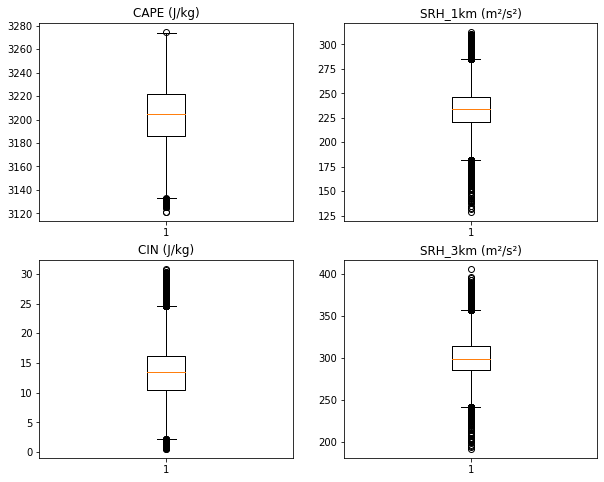

In [33]:
#Create BoxPlots of The Data

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize =(10,8))

#CAPE
axs[0,0].boxplot(CAPE[0,:])
axs[0,0].set_title('CAPE (J/kg)')

#CIN 
axs[1,0].boxplot(CIN[0,:])
axs[1,0].set_title('CIN (J/kg)')

#SRH1km
axs[0,1].boxplot(SRH1km)
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(SRH3km)
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

Text(0.5, 1.0, 'SRH_3km (m²/s²)')

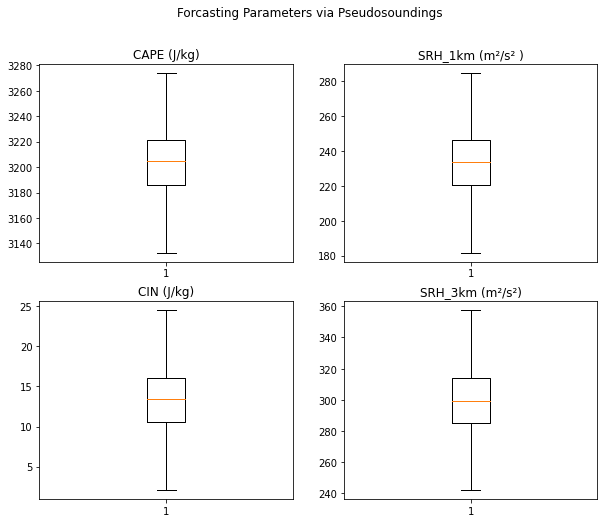

In [37]:
#Plot Box and Whisker Plots For ALL Parameters (w/o Outlier Points)

fig, axs = plt.subplots(nrows =2, ncols = 2, figsize = (10,8))

fig.suptitle('Forcasting Parameters via Pseudosoundings')

#CAPE
axs[0,0].boxplot(CAPE[0,:], 0, '')
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(CIN[0,:], 0, '')
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(SRH1km, 0, '')
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2 )')

#SRH3km
axs[1,1].boxplot(SRH3km, 0, '')
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')



# MLCAPE 

In [3]:
#Read Instantaneousinst_data

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'

inst_data = np.load(path+'instantaneous_data.npz')
points_data = np.load(path+'all_raw_interp_data.npz')

inst_P = inst_data['P']
inst_T = inst_data['T']
inst_Td = inst_data['Td']
inst_Th = inst_data['Th']
inst_qv = inst_data['qv']
inst_u = inst_data['u']
inst_v = inst_data['v']
inst_w = inst_data['w']
inst_zvort = inst_data['zvort']
inst_parc_T = inst_data['parc_T']
inst_CAPE = inst_data['CAPE']
inst_CIN = inst_data['CIN']
inst_SRH1km = inst_data['SRH1km']
inst_SRH3km = inst_data['SRH3km']
inst_MLCAPE = inst_data['MLCAPE']
inst_MLCIN = inst_data['MLCIN']

#Original Trajectory Points
points = points_data['interp_points']

#Ground Relative Winds
offset_u = 12.2
offset_v = 12.5 
gr_u = inst_u[0]+offset_u
gr_v = inst_v[0]+offset_v
inst_gr_wind = np.sqrt((gr_u**2)+(gr_v**2))

In [5]:
#Load The pseudo_data

path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'
pseudo_data = np.load(path+'pseudo_data.npz')
points_data = np.load(path+'all_raw_interp_data.npz')

#Data Interpolated to Model Grid
P = pseudo_data['P']
T = pseudo_data['T']
Th = pseudo_data['Th']
Td = pseudo_data['Td']
qv = pseudo_data['qv']
u = pseudo_data['u']
v = pseudo_data['v']
w = pseudo_data['w']
zvort = pseudo_data['zvort']
parc_T = pseudo_data['parc_T']
CAPE = pseudo_data['CAPE']
CIN = pseudo_data['CIN']
SRH1km = pseudo_data['SRH1km']
SRH3km = pseudo_data['SRH3km']
MLCAPE = pseudo_data['MLCAPE']
MLCIN = pseudo_data['MLCIN']

#Original Trajectory Points
points = points_data['interp_points']

#Ground Relative Winds
offset_u = 12.2 
offset_v = 12.5 
gr_u = u[0] + offset_u
gr_v = v[0] + offset_v
gr_wind = np.sqrt((gr_u**2)+(gr_v**2)) 


FileNotFoundError: [Errno 2] No such file or directory: '/storage/work/bsh5393/Variability Study/Data/InterpolationData/RawTrajectories/raw_data_2_grid.npz'

In [ ]:
#COMPUTE MLCAPE For Pseudo & Instantaneous Profiles (over lowest 100mb)

#Storage For MLCAPE, MLCIN
pseudo_MLCAPE = np.zeros(P.shape[1])
pseudo_MLCIN = np.zeros(P.shape[1])
inst_MLCAPE = np.zeros(P.shape[1])
inst_MLCIN = np.zeros(P.shape[1])

for x in tqdm(np.arange(0,P.shape[1],1)):
    #Pseudo
    pseudo = (mpcalc.mixed_layer_cape_cin(P[:,x]*units.Pa, T[:,x]*units.degK, Td[:,x]*units.degK))
    pseudo_MLCAPE[x],pseudo_MLCIN[x] = [pseudo[0].magnitude, pseudo[1].magnitude]
    
    #Instantaneous
    inst = mpcalc.mixed_layer_cape_cin(inst_P[:,x]*units.Pa, inst_T[:,x]*units.degK, inst_Td[:,x]*units.degK)
    inst_MLCAPE[x], inst_MLCIN[x] = [inst[0].magnitude, inst[1].magnitude]

 94%|█████████▍| 105959/112225 [5:01:10<17:14,  6.06it/s] 

In [ ]:
#Save ML Data

#Pseudo
path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'
filename = 'pseudo_data'

np.savez(path+filename,P = P, T = T, Th = Th, Td = Td, qv = qv, u = u, v = v, w = w, 
         zvort = zvort, parc_T = parc_T, CAPE = CAPE, CIN = CIN, SRH1km = SRH1km, 
         SRH3km = SRH3km, MLCAPE = pseudo_MLCAPE, MLCIN = pseudo_MLCIN)

In [ ]:
#Instantaneous
path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'
filename = 'instantaneous_data'

np.savez(path+filename, P = inst_P, T = inst_T, Td = inst_Td, Th = inst_Th, qv = inst_qv, 
        u = inst_u, v = inst_v, w = inst_w, zvort = inst_zvort, parc_T = inst_parc_T, CAPE = inst_CAPE,
        CIN = inst_CIN, SRH1km = inst_SRH1km, SRH3km = inst_SRH3km, MLCAPE = inst_MLCAPE, MLCIN = inst_MLCIN)

In [36]:
path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/InterpolationData/RawTrajectories/'
x = np.load(path+'instantaneous_data.npz')
for k in x.iterkeys():
    print(k)

P
T
Td
Th
qv
u
v
w
zvort
parc_T
CAPE
CIN
SRH1km
SRH3km
MLCAPE
MLCIN


/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: NpzFile.iterkeys is deprecated in python 3, to match the removal of dict.iterkeys. Use .keys() instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'SRH_3km (m²/s²)')

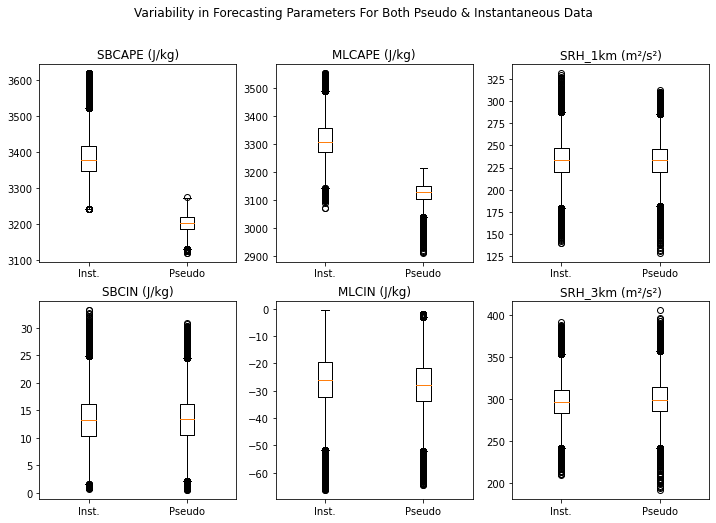

In [10]:
#Combine Peudo & Instantaenous Boxplots w/ MLCAPE/MLCIN included (w/ Outliers)


fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (12,8))

fig.suptitle('Variability in Forecasting Parameters For Both Pseudo & Instantaneous Data')

labels = ['Inst.','Pseudo']

#CAPE
axs[0,0].boxplot([inst_CAPE[0], CAPE[0]], labels = labels)
axs[0,0].set_title('SBCAPE (J/kg)')

#CIN 
axs[1,0].boxplot([inst_CIN[0], CIN[0]], labels = labels)
axs[1,0].set_title('SBCIN (J/kg)')

#MLCAPE 
axs[0,1].boxplot([inst_MLCAPE, MLCAPE], labels = labels)
axs[0,1].set_title('MLCAPE (J/kg)')

#MLCIN 
axs[1,1].boxplot([inst_MLCIN, MLCIN], labels = labels)
axs[1,1].set_title('MLCIN (J/kg)')

#SRH1km
axs[0,2].boxplot([inst_SRH1km, SRH1km], labels = labels)
axs[0,2].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km 
axs[1,2].boxplot([inst_SRH3km, SRH3km], labels = labels)
axs[1,2].set_title('SRH_3km (m\u00b2/s\u00b2)')

Text(0.5, 1.0, 'SRH_3km (m²/s²)')

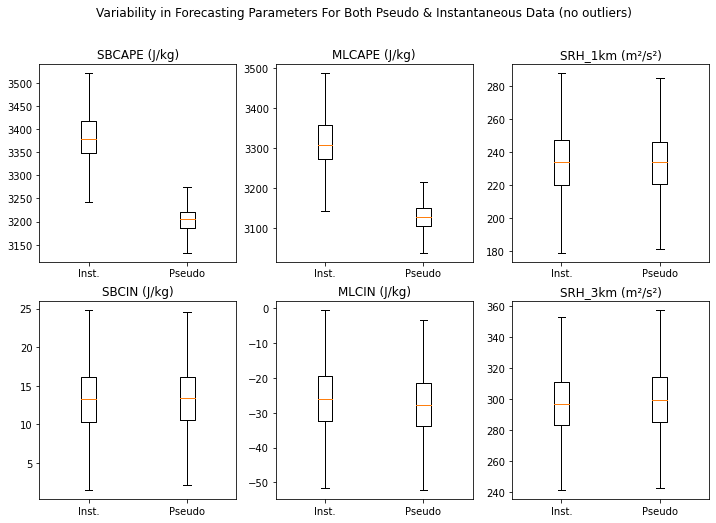

In [12]:
#Combine Peudo & Instantaenous Boxplots w/ MLCAPE/MLCIN included (w/o Outliers)


fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (12,8))

fig.suptitle('Variability in Forecasting Parameters For Both Pseudo & Instantaneous Data (no outliers)')

labels = ['Inst.','Pseudo']

#CAPE
axs[0,0].boxplot([inst_CAPE[0], CAPE[0]], 0,'', labels = labels)
axs[0,0].set_title('SBCAPE (J/kg)')

#CIN 
axs[1,0].boxplot([inst_CIN[0], CIN[0]], 0,'', labels = labels)
axs[1,0].set_title('SBCIN (J/kg)')

#MLCAPE 
axs[0,1].boxplot([inst_MLCAPE, MLCAPE], 0,'', labels = labels)
axs[0,1].set_title('MLCAPE (J/kg)')

#MLCIN 
axs[1,1].boxplot([inst_MLCIN, MLCIN], 0,'', labels = labels)
axs[1,1].set_title('MLCIN (J/kg)')

#SRH1km
axs[0,2].boxplot([inst_SRH1km, SRH1km], 0,'', labels = labels)
axs[0,2].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km 
axs[1,2].boxplot([inst_SRH3km, SRH3km], 0,'', labels = labels)
axs[1,2].set_title('SRH_3km (m\u00b2/s\u00b2)')

# Create Reflectivity Variability GIF

In [8]:
#Read in Reflectivity, Vorticity, and w Files

reflect = []
vort = []
wmax = []

for x in tqdm(np.arange(1,len(storm16_files),1)):
    dbz = xr.open_dataset(storm16_data_path + storm16_files[x])['dbz']
    vorticity = xr.open_dataset(storm16_data_path + storm16_files[x])['zvort']
    vel = xr.open_dataset(storm16_data_path  + storm16_files[x])['winterp']
    
    reflect.append(dbz)
    vort.append(vorticity)
    wmax.append(vel)
    


100%|██████████| 120/120 [00:07<00:00, 15.02it/s]


/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


([], [])

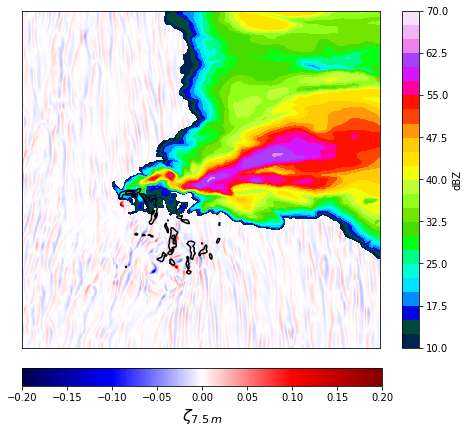

In [9]:
#Create Images
fig = fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)


vortcolormesh = plt.pcolormesh(x_data,y_data, vort[0].isel(time = 0, nk = 0), cmap = 'seismic', alpha = 1, vmin = -.2, vmax = .2)
#refcolormesh = plt.pcolormesh(x_data, y_data, reflect[0].isel(time = 0, nk = 17), cmap = 'RdYlGn_r', alpha = .05)
refcolormesh = plt.contourf(x_data,y_data, reflect[0].isel(time = 0, nk = 17),levels = [10,12.5,15,17.5,20,22.5,25,27.5, 30,32.5, 35,37.5, 
                                                                                        40,42.5, 45,47.5, 50,52.5, 55,57.5, 60,62.5, 65,67.5, 70], vmin = 10, vmax = 70, cmap = 'gist_ncar') #522 m
wcolormesh = plt.contour(x_data,y_data, wmax[0].isel(time = 0, nk = 17), levels = [5,10,15,20,25,30], colors = 'k') #522 m 


hcolorbar = fig.colorbar(vortcolormesh, label = r'$\zeta_{7.5 \, m}$', orientation = 'horizontal', pad = 0.075, shrink=0.8)
hcolorbar.set_label(r'$\zeta_{7.5 \, m}$', fontsize=16)
hcolorbar.ax.set_position([0.125, -0.24, 0.625, 0.5])

vcolorbar = fig.colorbar(refcolormesh, label = 'dBZ', orientation = 'vertical')



plt.xlim(-25,5)
plt.ylim(0,30)
#plt.title(f"Reflectivity at z = 522 m. t = {30*(x+1)} s")
plt.xticks([])
plt.yticks([])



In [10]:
#Create Images
path = '/storage/work/bsh5393/Sandbox /Figures/Reflectivity/'
gifname = '/storage/work/bsh5393/Sandbox /Figures/Reflectivity/S16withzvortalt.gif'

fig = fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)

for x in tqdm(np.arange(0,len(wmax),1)):
    image_filename = "figure_%03d.png" % (x)

    vortcolormesh = plt.pcolormesh(x_data,y_data, vort[x].isel(time = 0, nk = 0), cmap = 'seismic', alpha = 1, vmin = -.2, vmax = .2)
    #refcolormesh = plt.pcolormesh(x_data, y_data, reflect[x].isel(time = 0, nk = 17), cmap = 'RdYlGn_r', alpha = .05)
    refcolormesh = plt.contourf(x_data,y_data, reflect[x].isel(time = 0, nk = 17),levels = [10,12.5,15,17.5,20,22.5,25,27.5, 30,32.5, 35,37.5, 
                                                                                            40,42.5, 45,47.5, 50,52.5, 55,57.5, 60,62.5, 65,67.5, 70], vmin = 10, vmax = 70, cmap = 'gist_ncar') #522 m
    wcolormesh = plt.contour(x_data,y_data, wmax[x].isel(time = 0, nk = 17), levels = [5,10,15,20,25,30], colors = 'k') #522 m 
    
   
    hcolorbar = fig.colorbar(vortcolormesh, label = r'$\zeta_{7.5 \, m}$', orientation = 'horizontal', pad = 0.075, shrink=0.8)
    hcolorbar.set_label(r'$\zeta_{7.5 \, m}$', fontsize=16)
    hcolorbar.ax.set_position([0.125, -0.24, 0.625, 0.5])
    
    vcolorbar = fig.colorbar(refcolormesh, label = 'dBZ', orientation = 'vertical')
    
    

    plt.xlim(-25,5)
    plt.ylim(0,30)
    #plt.title(f"Reflectivity at z = 522 m. t = {30*(x+1)} s")
    plt.xticks([])
    plt.yticks([])
    
    fig.savefig(path+image_filename)
    plt.clf()


  0%|          | 0/120 [00:00<?, ?it/s]/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 120/120 [04:08<00:00,  2.07s/it]


<Figure size 576x576 with 0 Axes>

In [31]:
gifname = '/storage/work/bsh5393/Sandbox /Figures/Reflectivity/S16notitle.gif'

#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.1
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
image_filenames = []
for image_filename in os.listdir(path):
    if image_filename != '.ipynb_checkpoints': #This is how you can exclude certain filenames from the animation
        image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[3:]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

In [ ]:
# This Cell Randomly Selects a point amongst the 112225, and plots the pseudo vs. instantaneous sounding


# Random Index
k = np.random.randint(0, P.shape[1])

# Initialize SkewT
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)

# Initialize Hodograph   
ax = plt.axes((1.01, 0.45, 0.43, 0.43))
h = metpy.plots.Hodograph(ax, component_range=45.)

# Add alternating grid increments
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)


# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)
    
# Cosmetic Touches
skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
skew.ax.set_ylabel('Pressure (hPa)')
        
#Relative Storm Motion 
offset_u = 12.2*units.meter_per_second
offset_v = 12.5*units.meter_per_second

# Plot Bunkers Storm Motion
h.ax.arrow(0, 0, offset_u.magnitude, offset_v.magnitude, linewidth=1.5, color='black', length_includes_head=True, head_width=1.5)

# ---------------------------------------------------------------------------------------------------------------

# Plot PseudoSounding
length = len(P[:,k][::8])
skew.plot(P[:,k]*units.Pa, T[:,k]*units.degK, color='r')
skew.plot(P[:,k]*units.Pa, Td[:,k]*units.degK, color = 'r')
skew.plot(P[:,k]*units.Pa, parc_T[:,k]*units.degK, color = 'r', linestyle = '--')
skew.plot_barbs(P[:,k][::8]*units.Pa, u[:,k][::8]*units.meter_per_second+offset_u, 
                v[:,k][::8]*units.meter_per_second+offset_v, color = 'r', xloc=1.06, y_clip_radius = 0.09)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Plot Pseudo Hodograph
h.plot(u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, color='r', linewidth = 0.8)

# Plot Instantaneous Sounding/Hodograph
length = len(inst_P[:,k][::8])
skew.plot(inst_P[:,k]*units.Pa, inst_T[:,k]*units.degK, color='b')
skew.plot(inst_P[:,k]*units.Pa, inst_Td[:,k]*units.degK, color = 'b')
skew.plot(inst_P[:,k]*units.Pa, inst_parc_T[:,k]*units.degK, color = 'b', linestyle = '--')
skew.plot_barbs(inst_P[:,k][::8]*units.Pa, inst_u[:,k][::8]*units.meter_per_second+offset_u, 
                inst_v[:,k][::8]*units.meter_per_second+offset_v, color = 'b', xloc=1.06, y_clip_radius = 0.09)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Plot Instantaneous Hodograph
h.plot(inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, color='b', linewidth = 0.8)

# ---------------------------------------------------------------------------------------------------------------------------------

# Compute Forecasting Parameters

# Pseudo Profile Parameters 
# CAPE/CIN (wrf)
Height = z_data*1000 #"Geopotential Height"
Terrain = 0 #Terrain (Assuming Flat Surface)
P_sfc = P[:,k][0]/100 # Surface Pressure
# WRF CAPE Computation
results = wrf.cape_3d(P[:,k]/100, T[:,k], qv[:,k], Height, Terrain, P_sfc, ter_follow = True, meta = True)
SBCAPE = results[0][0].values
SBCIN = results[1][0].values
SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                        u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                        depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
# LCL
p_LCL = mpcalc.lcl(P[:,k][0]*units.Pa, T[:,k][0]*units.degK, Td[:,k][0]*units.degK)[0]
SBLCL = mpcalc.pressure_to_height_std(p_LCL)
# Height indices for ~ 0, 6 km and BWD
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0
u_sfc = u[:,k][z_0km]
v_sfc = v[:,k][z_0km]
u_6km = u[:,k][z_6km]
v_6km = v[:,k][z_6km]
BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
# STP
STP = (SBCAPE/1500)*((2000-1000*SBLCL.magnitude)/1000)*(SRH1km.magnitude/150)*((200+SBCIN)/150)*(BWD/20)
        

# Instantaneous Profile Parameters
Height = z_data*1000 #"Geopotential Height"
Terrain = 0 #Terrain (Assuming Flat Surface)
inst_P_sfc = inst_P[:,k][0]/100 # Surface Pressure
# WRF CAPE Computation
results = wrf.cape_3d(inst_P[:,k]/100, inst_T[:,k], inst_qv[:,k], Height, Terrain, inst_P_sfc, ter_follow = True, meta = True)
inst_SBCAPE = results[0][0].values
inst_SBCIN = results[1][0].values
# Print Comparison
#print(f'Metpy: {CIN}, WRF: {SBCIN}')
inst_SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                        inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                        depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
# LCL
inst_p_LCL = mpcalc.lcl(inst_P[:,k][0]*units.Pa, inst_T[:,k][0]*units.degK, inst_Td[:,k][0]*units.degK)[0]
inst_SBLCL = mpcalc.pressure_to_height_std(inst_p_LCL)
# Height indices for ~ 0, 6 km and BWD
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0
u_sfc = inst_u[:,k][z_0km]
v_sfc = inst_v[:,k][z_0km]
u_6km = inst_u[:,k][z_6km]
v_6km = inst_v[:,k][z_6km]
BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
inst_BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
# STP
inst_STP = (inst_SBCAPE/1500)*((2000-1000*inst_SBLCL.magnitude)/1000)*(inst_SRH1km.m/150)*((200+inst_SBCIN)/150)*(inst_BWD/20)

# --------------------------------------------------------------------------------------------------------------------------

# List Forecasting Parameters in Text Box 

fig.patches.extend([plt.Rectangle((1.01, 0.1), 0.435, 0.33,
                                  edgecolor='black', facecolor='white',
                                  linewidth=1, alpha=1, transform=fig.transFigure,
                                  figure=fig)])
# Add each parameter title to the bottom right text box
plt.figtext(1.04, 0.38, 'SBCAPE: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.33, 'SBCIN: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.28, 'SBLCL: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.23, '0–1 km SRH: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.18, 'BWD: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.13, 'STP: ', weight='bold', fontsize=12.5,
            color='k')

# Plot PseudoValues
plt.figtext(1.18, 0.38, f'{round(float(SBCAPE), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.33, f'{round(float(SBCIN), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.28, f'{round(float(SBLCL.m), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.23, f'{round(SRH1km.m,1)}', fontsize=12.5, weight='bold',
            color='red')
plt.figtext(1.18, 0.18, f'{round(float(BWD), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.13, f'{round(STP,2)}', weight='bold', fontsize=12.5,
            color='red')


# Plot Instantaneous Values 
plt.figtext(1.26, 0.38, f'{round(float(inst_SBCAPE), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.33, f'{round(float(inst_SBCIN), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.28, f'{round(float(inst_SBLCL.m), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.23, f'{round(inst_SRH1km.m,1)}', fontsize=12.5, weight='bold',
            color='blue')
plt.figtext(1.26, 0.18, f'{round(float(inst_BWD), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.13, f'{round(inst_STP,2)}', weight='bold', fontsize=12.5,
            color='blue')

# Add Units to each parameters
plt.figtext(1.34, 0.38, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.33, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.28, 'km', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.23, '$\mathbf{{ m^2 \ s^{{-2}}}}$', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.18, 'm s$^{-1}$', weight='bold', fontsize=12.5,
            color='k')

# Save and Print Randomly Selected Point
print(k)

# Add subplot labels to skewT and hodograph 
plt.figtext(0.05, 0.9, 'a)', fontsize = 16, weight = 'bold')
plt.figtext(0.97, 0.9, 'b)', fontsize = 16, weight = 'bold')
plt.figtext(0.97, 0.43, 'c)', fontsize = 16, weight = 'bold')
# Show the plot
plt.show()

      


